# Machine Learning Prototype

The idea is that we're going to create several different models and compare performance. The statsmodel api returns a lot of useful metrics to evaulate our model performance, so we'll use that to begin with. We'll build up a simple intuitive, baseline model and progressively add more features to the model, as well as eventually testing with a new PCA matrix.

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from ml_metrics import rmse
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import statsmodels.api as sm


read in engineered data from previous notebook, 02 Exploratory Data Analysis. 

In [2]:
engineered_df = pd.read_csv("data/engineered_df.csv")
print(engineered_df.shape)
engineered_df.head()

(624437, 41)


,stars,log_useful,readability grades Kincaid,readability grades ARI,readability grades Coleman-Liau,readability grades FleschReadingEase,readability grades GunningFogIndex,readability grades LIX,readability grades SMOGIndex,readability grades RIX,...,sentence beginnings pronoun,sentence beginnings interrogative,sentence beginnings article,sentence beginnings subordination,sentence beginnings conjunction,sentence beginnings preposition,compound,neg,neu,pos
0,3,1.098612,4.957177,4.700499,6.923485,80.640964,9.080207,29.929432,9.210590,2.142857,...,3.0,0.0,1.0,0.0,0.0,0.0,0.1531,0.121,0.746,0.134
1,4,1.098612,6.355000,7.633561,9.309376,75.623333,9.503030,35.121212,9.324555,3.000000,...,1.0,0.0,3.0,0.0,0.0,0.0,0.9774,0.000,0.595,0.405
2,5,1.098612,5.863636,6.478182,9.483280,72.615455,11.066667,36.757576,10.416198,2.833333,...,4.0,0.0,1.0,0.0,0.0,0.0,0.9460,0.000,0.682,0.318
3,5,0.000000,5.882500,4.708750,6.936612,60.012500,9.100000,29.000000,7.743416,1.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.9531,0.000,0.305,0.695
4,2,0.693147,6.721212,7.461576,7.209448,79.528485,10.969697,35.909091,10.071068,3.222222,...,3.0,0.0,1.0,1.0,2.0,2.0,0.9123,0.088,0.688,0.224


In [3]:
X,y = engineered_df.drop(columns = ["log_useful"]), engineered_df.log_useful
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

### Initial Intuitive Baseline Model
Here we'll create and evaluate a baseline model with intuitive features. We'll use stars and number of characters in a review to predict the log usefulness of it. Remember we found from the previous notebook that lower rated reviews tend to be more useful, as well as longer reviews being more useful. We made sense of this by noticing that the more stars the user gave the restaurant business, the shorter their review was because when people are pleased they're much more likely to leave a generic positive comment and not necessilarly comment on exactly what it was that they liked. On the flip side, lower rated reviews tend to be longer because when someone doesn't have a positive experience, if they're going to leave a review they're almost certainly going to say exactly what it was that made their experience negative so that those reading their review can understand exactly where their sentiment is coming from. 

In [4]:
smresults = smf.ols(formula = 'log_useful ~ Q("sentence info characters")', data=engineered_df).fit()
smresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_useful   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                 9.796e+04
Date:                Thu, 12 Mar 2020   Prob (F-statistic):               0.00
Time:                        18:20:48   Log-Likelihood:            -5.2959e+05
No. Observations:              624437   AIC:                         1.059e+06
Df Residuals:                  624435   BIC:                         1.059e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.1702      0.001    163.148      0.000       0.168       0.172
Q("sentence info characters")     0.0006   1.81e-06    312.985      0.000       0.001       0.001
==============================================================================
Omnibus:                   156588.192   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           411495.732
Skew:                           1.357   Prob(JB):                         0.00
Kurtosis:                       5.906   Cond. No.                         841.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Observations
R-squared coefficient is not bad for just one feature. Intuitively, we can think of the R-squared here as equal to variation in log useful votes explained by the number of characters in a review, divided by the variation in log useful votes without taking the number of characters into account. Thus, if we had a R-squared value of one, that would signify that our feature for the number of characters in a review perfectly explains and accounts for all of the variance in our target variable, log useful votes. Thus we can interpret our score of .136 as 13.6% of the variance in log useful votes being explained by the number of characters.

Our F-statistic is relatively high. Similar to our R-squared coefficient but with a slightly modified denominator,  we can think of the F-statistic here as equal to variation in log useful votes explained by the number of characters in a review, divided by the variation in log useful votes not explained by the number of characters in a review. Since our value is very high, this means the numerator is much larger than the demoninator, i.e. the variation in log useful votes explained by the number of characters in a review is much larger than the variation in log useful votes not explained by the number of characters in a review, so basically our feature has a lot more significance than non-significance. Note most importantly that Prob (F-statistic) is 0, which is what allows us to give credence to the F-statistic in the first place. You can think of this as meaning if we set the coefficient for the feature characters number of characters to 0, meaning our model doesn't use this feature at all when predicting the log useful votes and only uses the bias (intercept), then our model would be just as good as it was when we did use this feature for our predictions. So, since this 0 that means we are confident that our model would be a lot worse without this feature. 

Two things to note here that we discovered in our previous notebook, Exploratory Data Analysis, which are backed up here by our linear model. First, the coefficient for number of characters is positive, which is indictive of a positive correlation between this and the target variable log useful votes for a review. Secondly, A skew of 1.357 means that our target variable log useful votes is right skewed.


### Adding Number of Stars to Baseline Model

In [5]:
smresults = smf.ols(formula = 'log_useful ~ stars + Q("sentence info characters")', data=engineered_df).fit()
smresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_useful   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                 4.954e+04
Date:                Thu, 12 Mar 2020   Prob (F-statistic):               0.00
Time:                        18:20:48   Log-Likelihood:            -5.2911e+05
No. Observations:              624437   AIC:                         1.058e+06
Df Residuals:                  624434   BIC:                         1.058e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.2340      0.002    101.517      0.000       0.229       0.238
stars                            -0.0159      0.001    -31.007      0.000      -0.017      -0.015
Q("sentence info characters")     0.0006   1.84e-06    303.170      0.000       0.001       0.001
==============================================================================
Omnibus:                   156710.909   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414222.628
Skew:                           1.356   Prob(JB):                         0.00
Kurtosis:                       5.927   Cond. No.                     1.90e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Observations

Similar R-squared. F-statistic, P(F-statistic), and  coefficient for number of characters remain unchanged. Coefficient for number of stars is negative, meaning there our model has detected a negative correlation between log useful votes and number of stars for a review. This is another trend that we picked up on in the previous notebook that is now backed by the model.

There's one other subtle difference in our summary with this model compared to the last. Notice how much higher the conditional number is here, which is essentially a measure of multicollinearity. Multicollinearity is usually viewed in a negative light because ideally you'd like indepence between your features, however it's helpful for this case because it helps with intrepretability. In this sense, it can be intrepretted as there being a high correlation between number of stars for a review and the number of characters in a review. Again, this is incredibly reassuring to see as this was another trend that we picked up on in our Exploratory Data Analysis, which showed that on average, the less stars a review has the more characters it has, which we coupled with the fact that the more characters a review has the more useful it is.  

## Deciding The Best Feature Matrix

In the previous notebook, we designed a feature matrix with over 35 NLP features and performed PCA on it. PCA showed us that the first two principal components accounted for just over 70% of the variance in the data. Additionally, we saw that the first principal component's coefficients were highest for our sentiment features, namely stars. The second principal component's coefficients were highest in relation to our category of "sentence info" NLP features, which includes number of characters. This goes hand in hand with why we chose our previous two baseline features to be these. 

Now, we can try and determine what additional features we can include to help the performance of our linear model. There's several metrics we can use to evaluate the performance of our model. We'll look at R-squared, Adjusted R-squared, AIC & BIC, and finally RMSE. Because I haven't gone into the meaning behind some of these terms before, so I'll give a quick overview of what they mean in the context of our model. 

AIC & BIC - These tools of information criterion are widely used in model selection. Roughly, these can be seen as measurements of the tradeoff between goodness of fit and number of variables for a statistical model. Without getting too mathy, we can give the formula for each and a brief description of what's going on

$BIC = \log(n)*k - 2\log(L)$

$AIC = 2*k - 2\log(L)$

where k is the number of features/columns, and n is the number of samples/rows we're using. L is essentially our measure of goodness of fit, so we want this to be high. Our first term in the BIC formula scales with the number of data points and features, while AIC scales with the just the number of features. Since L is a measure of the goodness of fit of our model, obviously we want the second term in both equations to be as higher as possible, which means that we'd like both AIC and BIC to be as low as possible. 

Adjusted R-squared: Similar to r-squared, this takes into account the number of features used to predict by the model. The adjusted r-squared increase only if the new term improves the model more than what would be expected by chance. In contrast, this value decreases when a feature improves the model by less than expected chance, meaning that if we just added a new feature and the adjusted r-squared went down, then this feature doesn't improve the model by a sufficient amount.


PCA performs best when all of the variables have the same potential weight. In order to do that, we'll use MinMaxScaler and change all feature variables to be in the range [0, 1], but also keeps the same proportion between each value.

In [6]:
pca_X = MinMaxScaler(feature_range=[0, 1]).fit_transform(X_train)
pca = PCA().fit(pca_X)
pca_X = pca.fit_transform(pca_X)
pca_X = pd.DataFrame(pca_X)

In [7]:
new_pca_cols = {}
i = 0
for col in pca_X.columns:
    new_pca_cols[col] = "PCA_{}".format(i)
    i += 1
pca_X = pca_X.rename(columns = new_pca_cols)

In [8]:
pca_names_concated = 'stars + Q("sentence info characters")'
r2_list, r2_adj_list, aic_list, bic_list, rmse_list_train, rmse_list_test = [],[],[],[],[],[]
X_tr_sub = X_train[["stars", "sentence info characters"]]
X_tr_sub.reset_index(inplace = True)
for num_cols, col in enumerate(pca_X.columns):
    num_cols += 1
    pca_names_concated = pca_names_concated  + " + {}".format(col) 
    formula = 'log_useful ~ ' + pca_names_concated
    pca_names_concated = pca_names_concated  + " + {}".format(col)
    #6-Fold Cross-Validation with the training set
    kf = KFold(n_splits=6, random_state = 13)
    rmse_train_total = rmse_test_total = aic_total = bic_total = r2_train_total = r2_adj_total = 0
    pcaX_subset = pca_X.iloc[:, :num_cols]
    pcaX_subset.reset_index(inplace = True)
    hybrid_df_subset = pd.concat([X_tr_sub, pcaX_subset], axis = 1)
    hybrid_df_subset.drop(columns = ['index'], inplace = True)
    for train_index, val_index in kf.split(hybrid_df_subset, y_train):
        X_tr, X_val = hybrid_df_subset.iloc[train_index], hybrid_df_subset.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        X_tr['log_useful'] = y_tr
        formula = 'log_useful ~ ' + pca_names_concated
        sm_OLS = smf.ols(formula, data=X_tr).fit()
        X_val = sm.add_constant(X_val)
        y_val_pred = sm_OLS.predict(X_val)
        y_train_pred = sm_OLS.predict(X_tr)
        rmse_test_total += rmse(actual = y_val, predicted = y_val_pred)
        rmse_train_total += rmse(actual = y_tr, predicted = y_train_pred)
        aic_total += sm_OLS.aic
        bic_total += sm_OLS.bic
        r2_train_total += sm_OLS.rsquared
        r2_adj_total += sm_OLS.rsquared_adj
    rmse_list_train.append(rmse_train_total / 6)
    rmse_list_test.append(rmse_test_total / 6)
    aic_list.append(aic_total / 6)
    bic_list.append(bic_total / 6)
    r2_list.append(r2_train_total / 6)
    r2_adj_list.append(r2_adj_total / 6 )

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


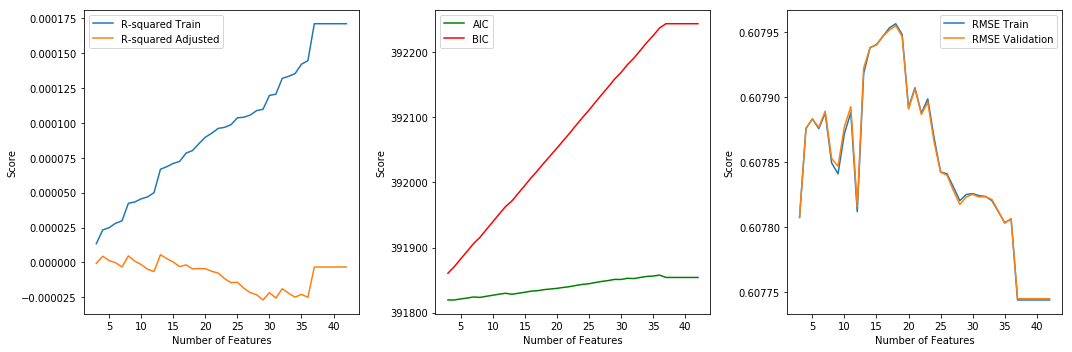

In [9]:
f, ax = plt.subplots(1,3, figsize = (15,5))
num_features = np.arange(3,43)

plt.subplot(131)
plt.plot(num_features, r2_list, label = "R-squared Train")
plt.plot(num_features, r2_adj_list, label = "R-squared Adjusted")
plt.legend(loc='best')
plt.xlabel('Number of Features')
plt.ylabel("Score")

plt.subplot(132)
plt.plot(num_features, aic_list, label = "AIC", color = "green")
plt.plot(num_features, bic_list, label = "BIC", color = "red")
plt.legend(loc='best')
plt.xlabel('Number of Features')
plt.ylabel("Score")

plt.subplot(133)
plt.plot(num_features, rmse_list_train, label = "RMSE Train")
plt.plot(num_features, rmse_list_test, label = "RMSE Validation")
plt.xlabel('Number of Features')
plt.ylabel("Score")
plt.legend(loc='best')

plt.tight_layout()
plt.show()

So obviously there's a lot going on here that requires explanation. There's two main points of interest here regarding number of features, namely 13 and 37 features. 

Starting off with examining the results after 13 features, this is a particular interesting point from adjusted r_squared and RMSE metrics. This marks a point where the adjusted rsquared reaches a global maximum and is followed by a steady descent after adding more features, suggesting a lot of these additional predictors aren't helping our model much. However, we can see that the squared coefficient continues to increase. Our BIC clearly has a linear progression, however AIC tells a different story. Noting that the AIC was already rising previous to 13 features, this  seems to be the beginning of a steady, more progressive raise in our AIC metric. Examining the RMSE we also see an interesting trend ending and another beginning at 13 features. This marks the end of what looks like a rather exponential decrease in our loss, and the beginning of a stagnation in the loss followed by an eventual brief, milder decrease in RMSE. 

The second point of interest is 37 features. The Rsquared coefficient reaches its apex here, while the adjusted rsquared reaches a local maximum, both of which are good signs. This may signify that the particular feature that we added was particularly useful, as examining the trends before and after the addition of this feature show that we weren't getting much with the other features. The RMSE appears to approach its minimum around 27 features, and loiter around there with the addition of every feature after that. 

### Random Forest Regression Model

Now we'll look at using more advanced models in order to gain insight into oru data. We'll do some hyperparameter tuning in order to find the best parameters for our model, and give a brief overview of what these hyperparameters mean.

n estimators-  number of trees in random forest
max depth - Maximum number of levels in tree
min samples split - Minimum number of samples required to split a node
min samples leaf - Minimum number of samples required at each leaf node
bootstrap - If true, we sample with replacement

In [10]:
X_tr_sub.drop(columns = ["index"], inplace = True)
pcaX_subset = pca_X.iloc[:, :35]
hybrid_df = pd.concat([X_tr_sub, pcaX_subset], axis = 1)
hybrid_df.reset_index(inplace=True)
hybrid_df["log_useful"] = y_train.values
hybrid_df = hybrid_df.sample(frac=.04, replace = False,random_state=13)
hybrid_df.drop(columns = ["index"], inplace = True)
print(hybrid_df.shape)
hybrid_df.isna().sum()

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(17484, 38)


stars                       0
sentence info characters    0
PCA_0                       0
PCA_1                       0
PCA_2                       0
PCA_3                       0
PCA_4                       0
PCA_5                       0
PCA_6                       0
PCA_7                       0
PCA_8                       0
PCA_9                       0
PCA_10                      0
PCA_11                      0
PCA_12                      0
PCA_13                      0
PCA_14                      0
PCA_15                      0
PCA_16                      0
PCA_17                      0
PCA_18                      0
PCA_19                      0
PCA_20                      0
PCA_21                      0
PCA_22                      0
PCA_23                      0
PCA_24                      0
PCA_25                      0
PCA_26                      0
PCA_27                      0
PCA_28                      0
PCA_29                      0
PCA_30                      0
PCA_31    

In [11]:
X_sub,y_sub = hybrid_df.drop(columns = ["log_useful"]), hybrid_df.log_useful
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.3, random_state=13)
X_train_sub.head()
n_estimators = [10]
max_features = ['auto', 'sqrt']
max_depth = [5,10,15, None]
min_samples_split = [10]
min_samples_leaf = [4]
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators, 'min_samples_leaf': min_samples_leaf, 
              'min_samples_split': min_samples_split, 'bootstrap': bootstrap, 'max_features': max_features, 
              'max_depth': max_depth}

In [12]:
rf = GridSearchCV(RandomForestRegressor(random_state=13), param_grid)
rf.fit(X_train_sub, y_train_sub)
opt_rf = rf.best_estimator_
print(rf.best_params_)

{'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 10}


In [13]:
opt_rf.score(X_train_sub, y_train_sub)

0.2286688723381152

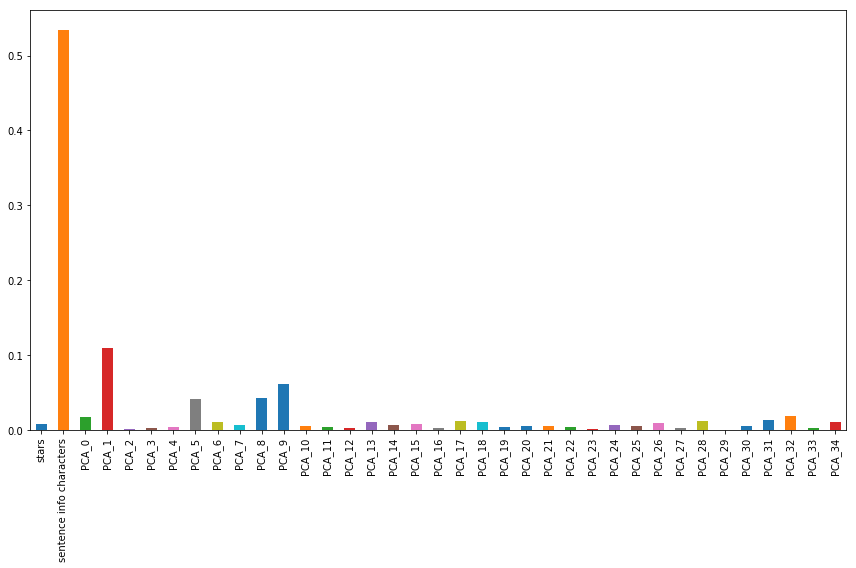

In [14]:
feature_significances = pd.Series(opt_rf.feature_importances_, index = X_sub.columns)
feature_significances.plot(kind = "bar", figsize = [12,8])
plt.tight_layout()